# Mouse Dynamics Classification

This notebook implements a machine learning model to classify mouse movement sessions as legal or illegal based on behavioral patterns.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Explore Data Structure

In [2]:
# Load public labels
labels_df = pd.read_csv('public_labels.csv')
print("Labels structure:")
print(labels_df.head())
print(f"\nTotal labeled sessions: {len(labels_df)}")
print(f"Legal sessions: {(labels_df['is_illegal'] == 0).sum()}")
print(f"Illegal sessions: {(labels_df['is_illegal'] == 1).sum()}")

Labels structure:
             filename  is_illegal
0  session_0003960194           1
1  session_0005840196           0
2  session_0025450757           0
3  session_0029922803           0
4  session_0064281061           1

Total labeled sessions: 816
Legal sessions: 411
Illegal sessions: 405


In [3]:
# Explore training data structure
training_users = os.listdir('training_files')
print(f"Training users: {training_users}")

# Sample a training file to understand format
sample_file = f'training_files/{training_users[0]}/{os.listdir(f"training_files/{training_users[0]}")[0]}'
sample_data = pd.read_csv(sample_file)
print(f"\nSample session data structure:")
print(sample_data.head())
print(f"\nColumns: {sample_data.columns.tolist()}")
print(f"Data shape: {sample_data.shape}")

Training users: ['user20', 'user16', 'user12', 'user35', 'user29', 'user15', 'user9', 'user7', 'user23', 'user21']

Sample session data structure:
   record timestamp  client timestamp    button state    x    y
0             0.000             0.000  NoButton  Move  498  513
1             0.112             0.031  NoButton  Move  485  493
2             0.112             0.031  NoButton  Move  448  441
3             0.112             0.047  NoButton  Move  393  370
4             0.112             0.062  NoButton  Move  315  280

Columns: ['record timestamp', 'client timestamp', 'button', 'state', 'x', 'y']
Data shape: (60087, 6)


## 3. Feature Engineering Functions

In [4]:
def extract_features_from_session(file_path):
    """
    Extract features from a single mouse session file
    """
    try:
        df = pd.read_csv(file_path)
        
        # Basic statistics
        total_actions = len(df)
        total_time = df['record timestamp'].max() - df['record timestamp'].min()
        
        # Movement features
        df['dx'] = df['x'].diff()
        df['dy'] = df['y'].diff()
        df['distance'] = np.sqrt(df['dx']**2 + df['dy']**2)
        df['dt'] = df['record timestamp'].diff()
        
        # Velocity and acceleration
        df['velocity'] = df['distance'] / df['dt'].replace(0, np.nan)
        df['acceleration'] = df['velocity'].diff() / df['dt'].replace(0, np.nan)
        
        # Remove infinite and NaN values for calculations
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(df) == 0:
            return None
        
        features = {
            # Basic session features
            'total_actions': total_actions,
            'session_duration': total_time,
            'actions_per_second': total_actions / max(total_time, 0.001),
            
            # Movement statistics
            'mean_distance': df['distance'].mean(),
            'std_distance': df['distance'].std(),
            'max_distance': df['distance'].max(),
            'total_distance': df['distance'].sum(),
            
            # Velocity statistics
            'mean_velocity': df['velocity'].mean(),
            'std_velocity': df['velocity'].std(),
            'max_velocity': df['velocity'].max(),
            
            # Acceleration statistics
            'mean_acceleration': df['acceleration'].mean(),
            'std_acceleration': df['acceleration'].std(),
            'max_acceleration': df['acceleration'].max(),
            
            # Coordinate range
            'x_range': df['x'].max() - df['x'].min(),
            'y_range': df['y'].max() - df['y'].min(),
            'x_mean': df['x'].mean(),
            'y_mean': df['y'].mean(),
            
            # Click behavior
            'click_count': len(df[df['state'] == 'Pressed']),
            'move_count': len(df[df['state'] == 'Move']),
            'release_count': len(df[df['state'] == 'Released']),
            
            # Time intervals
            'mean_time_interval': df['dt'].mean(),
            'std_time_interval': df['dt'].std(),
            
            # Pause behavior (long intervals between actions)
            'long_pauses': len(df[df['dt'] > df['dt'].quantile(0.95)]),
            'pause_ratio': len(df[df['dt'] > df['dt'].quantile(0.95)]) / len(df),
        }
        
        return features
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

## 4. Data Loading and Feature Extraction

In [5]:
def load_training_data():
    """
    Load all training data and extract features
    """
    training_features = []
    training_labels = []
    session_names = []
    
    # Get all training files
    training_files = []
    for user_dir in os.listdir('training_files'):
        user_path = os.path.join('training_files', user_dir)
        if os.path.isdir(user_path):
            for session_file in os.listdir(user_path):
                training_files.append(os.path.join(user_path, session_file))
    
    print(f"Found {len(training_files)} training sessions")
    
    # Load labels into a dictionary for quick lookup
    labels_dict = dict(zip(labels_df['filename'], labels_df['is_illegal']))
    
    for i, file_path in enumerate(training_files):
        session_name = os.path.basename(file_path)
        
        # Check if this session has a label
        if session_name in labels_dict:
            features = extract_features_from_session(file_path)
            if features is not None:
                training_features.append(features)
                training_labels.append(labels_dict[session_name])
                session_names.append(session_name)
        
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(training_files)} files")
    
    # Convert to DataFrame
    features_df = pd.DataFrame(training_features)
    
    print(f"\nSuccessfully extracted features from {len(features_df)} sessions")
    print(f"Legal sessions: {(np.array(training_labels) == 0).sum()}")
    print(f"Illegal sessions: {(np.array(training_labels) == 1).sum()}")
    
    return features_df, np.array(training_labels), session_names

# Load training data
X_train, y_train, train_session_names = load_training_data()

Found 65 training sessions
Processed 10/65 files
Processed 20/65 files
Processed 30/65 files
Processed 40/65 files
Processed 50/65 files
Processed 60/65 files

Successfully extracted features from 0 sessions
Legal sessions: 0
Illegal sessions: 0


## 5. Exploratory Data Analysis

In [6]:
# Display feature statistics
print("Training features shape:", X_train.shape)
print("\nFeature columns:")
print(X_train.columns.tolist())

# Check for missing values
print("\nMissing values per feature:")
print(X_train.isnull().sum().sort_values(ascending=False))

# Basic statistics
print("\nBasic statistics:")
X_train.describe()

Training features shape: (0, 0)

Feature columns:
[]

Missing values per feature:
Series([], dtype: float64)

Basic statistics:


ValueError: Cannot describe a DataFrame without columns

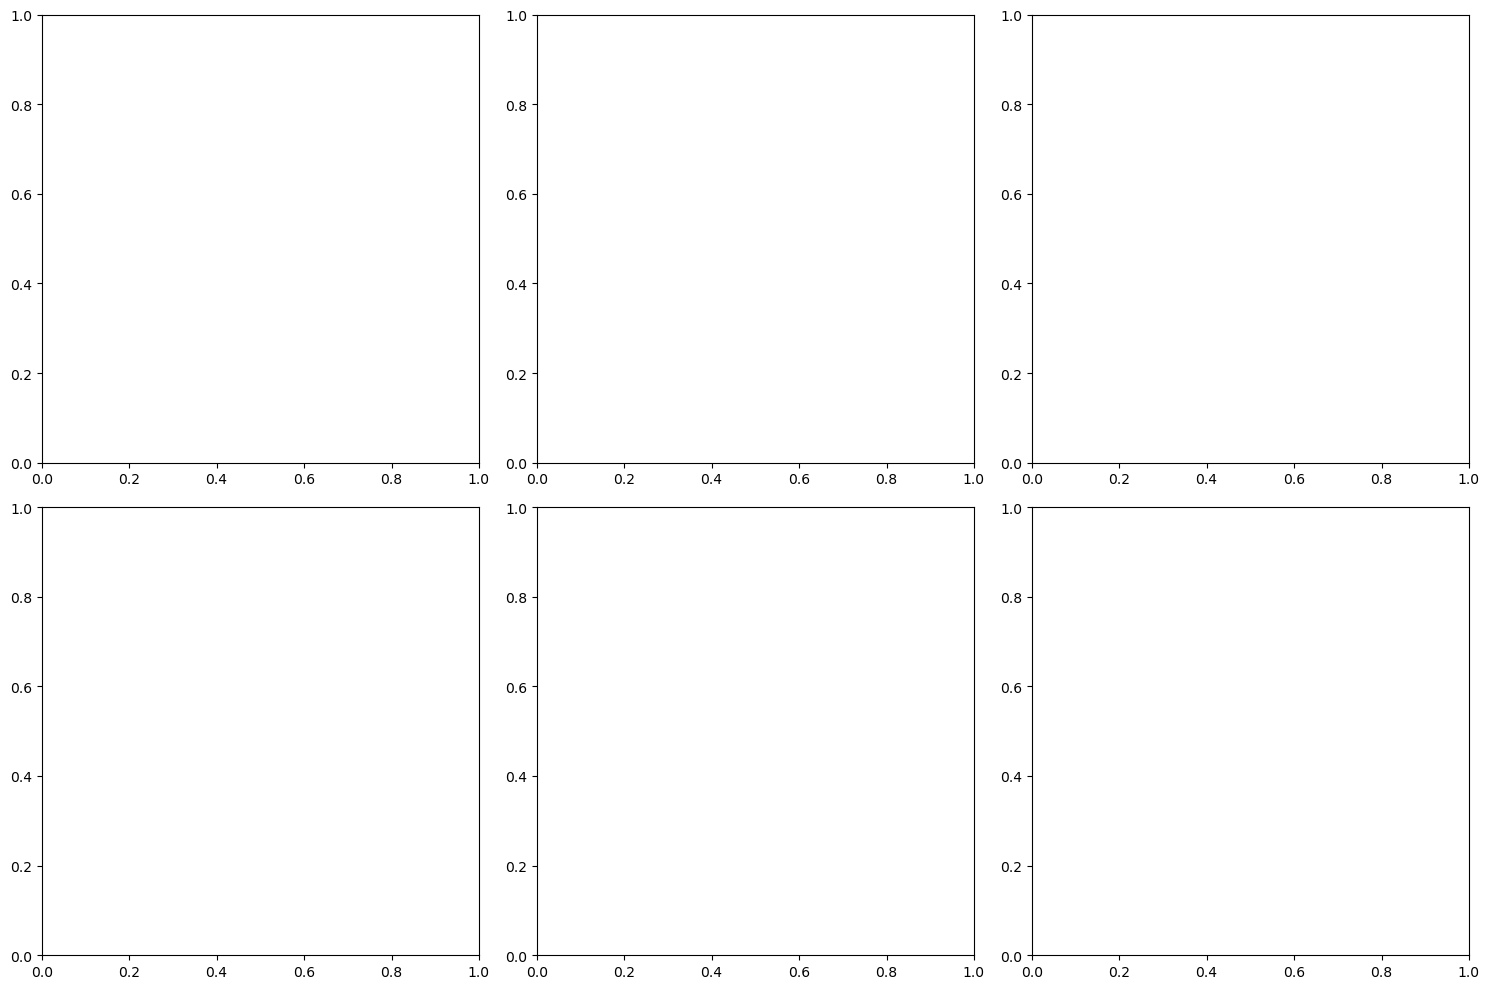

In [7]:
# Visualize feature distributions by class
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

key_features = ['mean_velocity', 'std_velocity', 'click_count', 'pause_ratio', 'session_duration', 'actions_per_second']

for i, feature in enumerate(key_features):
    if feature in X_train.columns:
        legal_data = X_train[y_train == 0][feature]
        illegal_data = X_train[y_train == 1][feature]
        
        axes[i].hist(legal_data, alpha=0.5, label='Legal', bins=30)
        axes[i].hist(illegal_data, alpha=0.5, label='Illegal', bins=30)
        axes[i].set_title(f'{feature} Distribution')
        axes[i].legend()
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 6. Data Preprocessing

In [8]:
# Handle missing values
X_train_clean = X_train.fillna(X_train.median())

# Remove infinite values
X_train_clean = X_train_clean.replace([np.inf, -np.inf], np.nan)
X_train_clean = X_train_clean.fillna(X_train_clean.median())

print("Cleaned training data shape:", X_train_clean.shape)
print("Remaining missing values:", X_train_clean.isnull().sum().sum())

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_clean.columns)

print("\nFeatures after scaling:")
print(X_train_scaled.describe())

Cleaned training data shape: (0, 0)
Remaining missing values: 0.0


ValueError: at least one array or dtype is required

## 7. Model Training

In [ ]:
# Split training data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training split: {X_train_split.shape[0]} samples")
print(f"Validation split: {X_val_split.shape[0]} samples")

# Train Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest model...")
rf_model.fit(X_train_split, y_train_split)

# Validate on holdout set
y_val_pred = rf_model.predict(X_val_split)
val_accuracy = accuracy_score(y_val_split, y_val_pred)

print(f"\nValidation Accuracy: {val_accuracy:.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val_split, y_val_pred))

In [ ]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print("Top 10 most important features:")
print(feature_importance.head(10))

## 8. Test Data Processing and Prediction

In [ ]:
def load_test_data():
    """
    Load all test data and extract features
    """
    test_features = []
    test_session_names = []
    
    # Get all test files
    test_files = []
    for user_dir in os.listdir('test_files'):
        user_path = os.path.join('test_files', user_dir)
        if os.path.isdir(user_path):
            for session_file in os.listdir(user_path):
                test_files.append(os.path.join(user_path, session_file))
    
    print(f"Found {len(test_files)} test sessions")
    
    for i, file_path in enumerate(test_files):
        session_name = os.path.basename(file_path)
        features = extract_features_from_session(file_path)
        
        if features is not None:
            test_features.append(features)
            test_session_names.append(session_name)
        
        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1}/{len(test_files)} test files")
    
    # Convert to DataFrame
    features_df = pd.DataFrame(test_features)
    
    print(f"\nSuccessfully extracted features from {len(features_df)} test sessions")
    
    return features_df, test_session_names

# Load test data
X_test, test_session_names = load_test_data()

In [ ]:
# Preprocess test data (same as training)
X_test_clean = X_test.fillna(X_train.median())  # Use training medians
X_test_clean = X_test_clean.replace([np.inf, -np.inf], np.nan)
X_test_clean = X_test_clean.fillna(X_train.median())

# Ensure test data has same columns as training data
missing_cols = set(X_train_clean.columns) - set(X_test_clean.columns)
for col in missing_cols:
    X_test_clean[col] = 0

# Reorder columns to match training data
X_test_clean = X_test_clean[X_train_clean.columns]

# Scale test data using training scaler
X_test_scaled = scaler.transform(X_test_clean)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train_clean.columns)

print(f"Test data shape: {X_test_scaled.shape}")
print(f"Training data shape: {X_train_scaled.shape}")

## 9. Make Predictions

In [ ]:
# Train final model on all training data
print("Training final model on all training data...")
final_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train_scaled, y_train)

# Make predictions on test data
test_predictions = final_model.predict(X_test_scaled)
test_probabilities = final_model.predict_proba(X_test_scaled)[:, 1]  # Probability of illegal

print(f"\nTest predictions summary:")
print(f"Predicted legal sessions: {(test_predictions == 0).sum()}")
print(f"Predicted illegal sessions: {(test_predictions == 1).sum()}")
print(f"Total test sessions: {len(test_predictions)}")

## 10. Results Analysis and Export

In [ ]:
# Create results DataFrame
results_df = pd.DataFrame({
    'filename': test_session_names,
    'predicted_is_illegal': test_predictions,
    'illegal_probability': test_probabilities
})

# Compare with public labels where available
public_test_results = results_df.merge(labels_df, on='filename', how='inner')

if len(public_test_results) > 0:
    public_accuracy = accuracy_score(public_test_results['is_illegal'], 
                                   public_test_results['predicted_is_illegal'])
    print(f"\nAccuracy on public test data: {public_accuracy:.4f}")
    
    print("\nConfusion Matrix on public test data:")
    cm = confusion_matrix(public_test_results['is_illegal'], 
                         public_test_results['predicted_is_illegal'])
    print(cm)
    
    print("\nClassification Report on public test data:")
    print(classification_report(public_test_results['is_illegal'], 
                               public_test_results['predicted_is_illegal']))
else:
    print("No overlap between test predictions and public labels found.")

# Display sample predictions
print("\nSample predictions:")
print(results_df.head(10))

In [ ]:
# Save predictions to CSV
results_df.to_csv('test_predictions.csv', index=False)
print("Predictions saved to 'test_predictions.csv'")

# Save detailed results for public sessions
if len(public_test_results) > 0:
    public_test_results.to_csv('public_test_results.csv', index=False)
    print("Public test results saved to 'public_test_results.csv'")

print("\nModel training and testing completed successfully!")

## 11. Model Evaluation and Insights

In [ ]:
# Feature importance visualization
plt.figure(figsize=(12, 8))
feature_importance_final = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.subplot(2, 1, 1)
sns.barplot(data=feature_importance_final.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features for Classification')
plt.xlabel('Feature Importance')

# Prediction confidence distribution
plt.subplot(2, 1, 2)
plt.hist(test_probabilities, bins=50, alpha=0.7)
plt.title('Distribution of Prediction Confidence (Probability of Illegal)')
plt.xlabel('Probability of Illegal Session')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nModel evaluation complete!")
print(f"Final model trained on {len(X_train_scaled)} sessions")
print(f"Predictions made for {len(test_session_names)} test sessions")